##Lung Cancer Detection Using Random Forest

# import libraries

In [2]:
#data frames and data manipulation
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Feature Engineering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

#Model 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Model Tracking

import mlflow
import mlflow.sklearn

## Data Preprocessing

In [3]:
#Load the dataset
df=pd.read_csv("/home/ubuntu/lung-cancer-random-forest/survey lung cancer.csv")
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


# Brief description of the dataset:

GENDER: The gender of the individual (Male or Female).

AGE: The age of the individual in years.

SMOKING: Indicates if the individual smokes ('2' for yes, '1' for no).

YELLOW_FINGERS: Denotes the presence of yellow fingers ('2' for yes, '1' for no), a potential sign associated with smoking.

ANXIETY: Indicates if the individual experiences anxiety ('2' for yes, '1' for no).

PEER_PRESSURE: Suggests if peer pressure influences the individual's habits ('2' for yes, '1' for no).

CHRONIC DISEASE: Indicates the presence of any chronic diseases ('2' for yes, '1' for no).

FATIGUE: Denotes if the individual frequently feels fatigued ('2' for yes, '1' for no).

ALLERGY: Indicates if the individual has allergies ('2' for yes, '1' for no).

WHEEZING: Represents whether the individual experiences wheezing ('2' for yes, '1' for no).

ALCOHOL CONSUMING: Indicates alcohol consumption habits ('2' for yes, '1' for no).

COUGHING: Represents whether the individual has a cough ('2' for yes, '1' for no).

SHORTNESS OF BREATH: Indicates if the individual experiences shortness of breath ('2' for yes, '1' for no).

SWALLOWING DIFFICULTY: Denotes difficulty in swallowing ('2' for yes, '1' for no).

CHEST PAIN: Indicates the presence of chest pain ('2' for yes, '1' for no).

LUNG_CANCER: The target variable, indicating whether the individual has lung cancer ('2' for yes, '1' for no).

In [4]:
df.shape
df.dtypes

GENDER                   object
AGE                       int64
SMOKING                   int64
YELLOW_FINGERS            int64
ANXIETY                   int64
PEER_PRESSURE             int64
CHRONIC DISEASE           int64
FATIGUE                   int64
ALLERGY                   int64
WHEEZING                  int64
ALCOHOL CONSUMING         int64
COUGHING                  int64
SHORTNESS OF BREATH       int64
SWALLOWING DIFFICULTY     int64
CHEST PAIN                int64
LUNG_CANCER              object
dtype: object

Check for null value

In [5]:
#Check for missing values
print(df.isnull().sum())

#Remove missing values 
df = df.dropna()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64


#Convert '1' for 'YES' and '0' for 'NO' to align with common practices in binary classification.

In [6]:
df.columns = df.columns.str.strip()
#Convert '2' to '1' and '1' to '0'
new_columns = ['SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 
                      'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING', 
                      'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH', 
                      'SWALLOWING DIFFICULTY', 'CHEST PAIN']

for col in new_columns:
    if col in df.columns:
        df[col] = df[col].map({2: 1, 1: 0})

# Convert 'YES' to '1' and 'NO' to '0' for the 'LUNG_CANCER' column
df['LUNG_CANCER'] = df['LUNG_CANCER'].map({'YES': 1, 'NO': 0})

df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,M,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,F,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,M,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,F,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


# Exploratory Data Analysis (EDA)

Box plot to show the relationship between age and gender

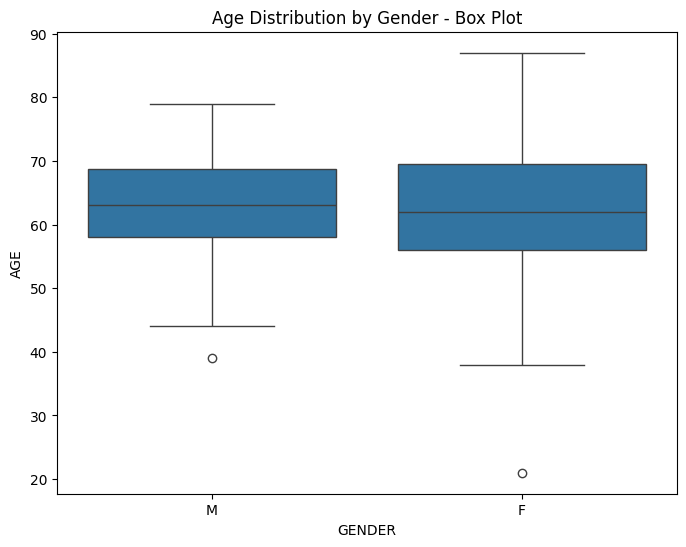

In [7]:
#Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='GENDER', y='AGE', data=df)
plt.title('Age Distribution by Gender - Box Plot')
plt.show()

The box plot visualizes the age distribution for two gender categories, Male (M) and Female (F). For both categories, the median age appears to be roughly the same, around the mid-60s. However, the age range for males extends slightly lower than for females, as indicated by the longer lower whisker and the presence of an outlier, suggesting that there are younger males in the dataset. The interquartile range (the box itself) is similar for both genders, indicating similar variability in age distribution among the middle 50% of the samples for both genders.

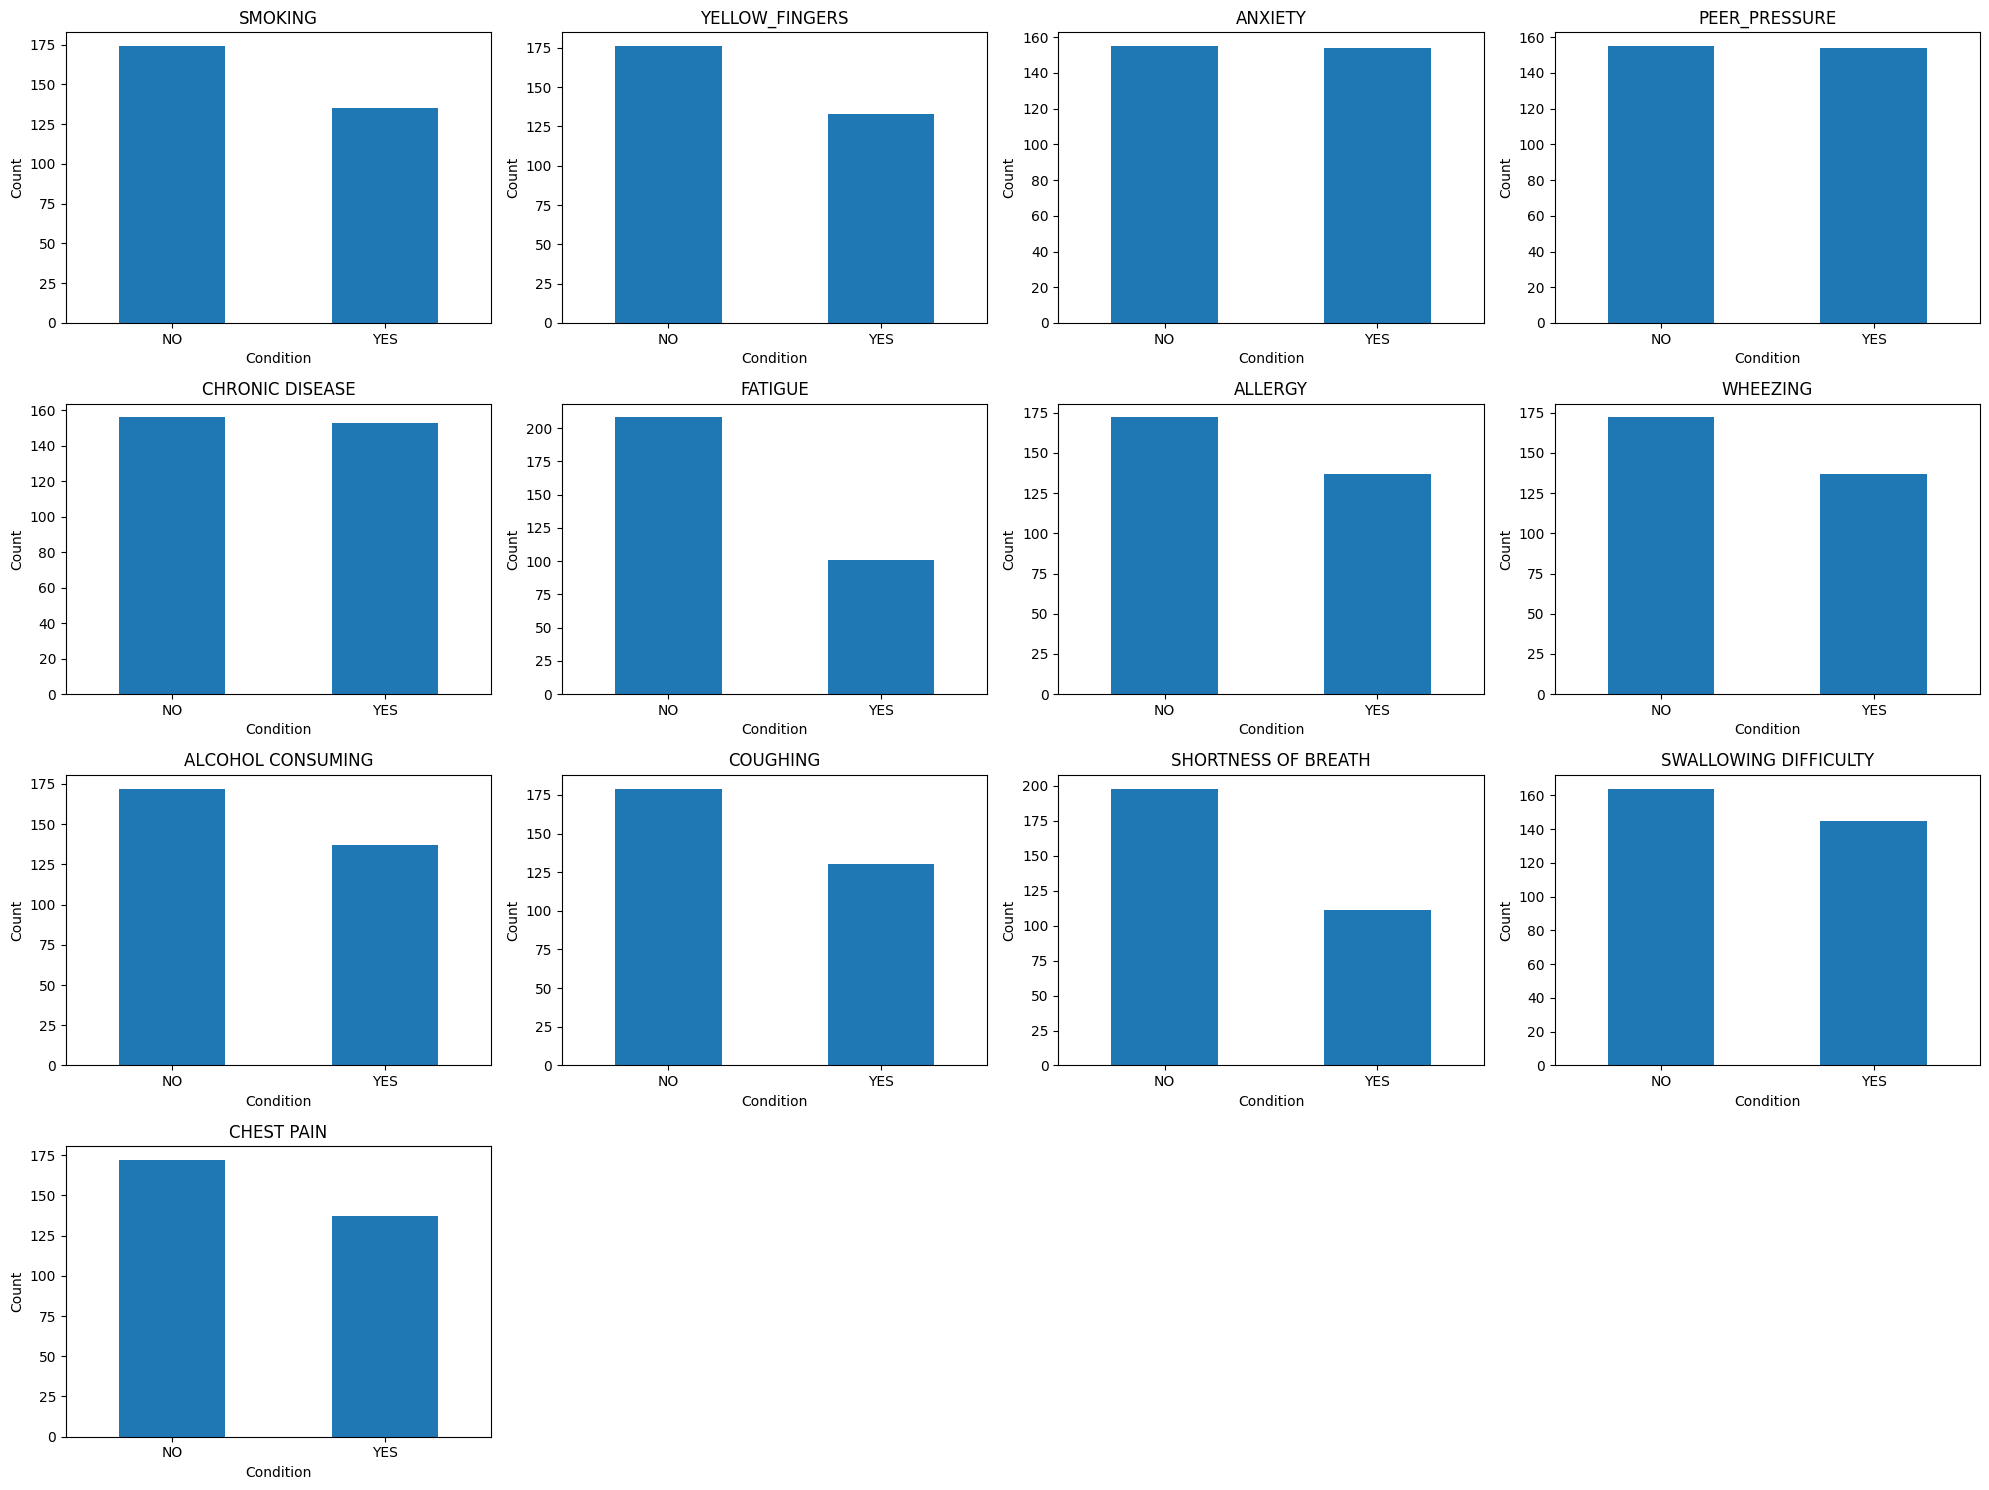

In [8]:
# Histogram for specified conditions

def plot_histograms(dataframe, columns_list):
    plt.figure(figsize=(20, 15))
    for i, col in enumerate(columns_list, 1):
        plt.subplot(4, 4, i)
        dataframe[col].value_counts().plot(kind='bar')
        plt.title(col)
        plt.xticks([0, 1], ['NO', 'YES'], rotation=0)
        plt.xlabel('Condition')
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_histograms(df, new_columns)

Most conditions appear to have a higher frequency of 'No' responses compared to 'Yes', indicating that a larger number of individuals in the sample do not exhibit these conditions. However, 'FATIGUE' and 'SHORTNESS OF BREATH' show a significantly higher number of 'Yes' responses, suggesting these symptoms are more commonly reported among the participants.

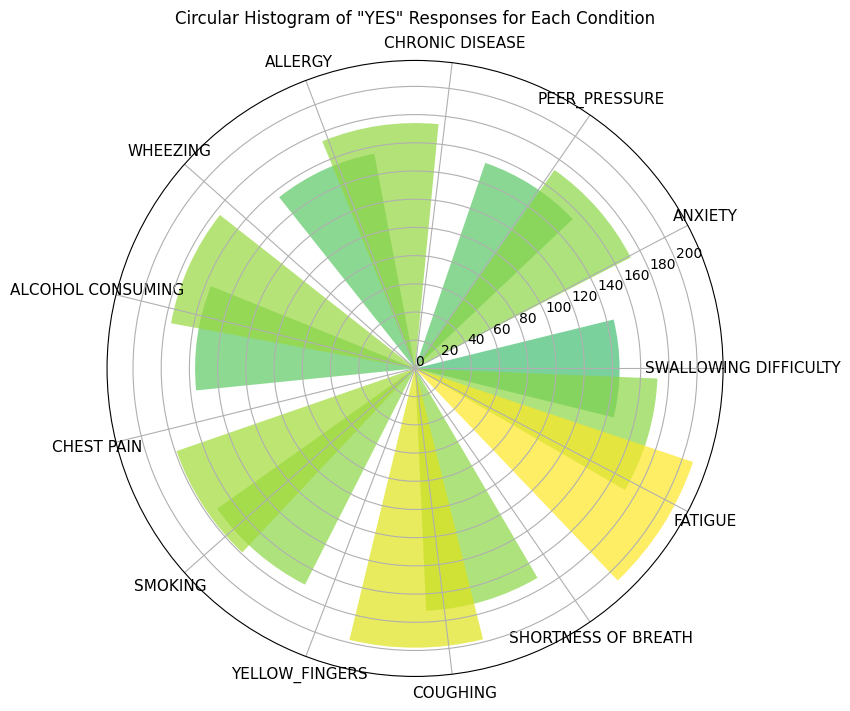

In [10]:
# Frequency of 'YES' response for each conditions

import matplotlib.pyplot as plt
import numpy as np

def create_circular_histogram(dataframe, columns_list):
    yes_counts = dataframe[columns_list].sum().sort_values()

    # Set up plot
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(111, polar=True)
    width = (2 * np.pi) / len(yes_counts)  # Recalculate width
    colors = plt.cm.viridis(yes_counts.values / float(max(yes_counts.values)))

    # Plotting bars
    bars = ax.bar(yes_counts.index, yes_counts.values, width=width, color=colors, alpha=0.7)

    # Set circumferences and radius
    ax.set_xticks(np.linspace(0, 2 * np.pi, len(yes_counts), endpoint=False))
    ax.set_xticklabels(yes_counts.index, fontsize=11, rotation=90)
    ax.set_yticks(np.arange(0, max(yes_counts.values), 20))
    ax.set_yticklabels(np.arange(0, max(yes_counts.values), 20))

    # Add title
    ax.set_title('Circular Histogram of "YES" Responses for Each Condition', va='bottom')
    ax.grid(True)

    plt.show()

create_circular_histogram(df, new_columns)

   

The histogram indicates a relatively uniform distribution across various health conditions, implying a potential correlation among them. This uniformity might suggest that the presence of one condition could be associated with the likelihood of others, which collectively could contribute to an increased risk of lung cancer.

# Feature Engineering
Create interaction terms to explore potential synergistic effects between demographic factors (like gender) and health conditions (like smoking). A cumulative risk score was created by summing various health condition indicators, providing a single metric that represents the overall health risk. Polynomial features for 'AGE' were generated to capture any non-linear relationships between age and lung cancer risk. Additionally, one-hot encoding was applied to the binned age categories, allowing machine learning models to better interpret these as distinct groups. Each of these steps aims to enhance the dataset's predictive power by uncovering more complex relationships within the data.

Transforming 'AGE' into bins or polynomial terms to helps in modeling non-linear relationships and interactions with the risk of lung cancer, which may not be captured by the raw numerical age. Similarly, encoding 'GENDER' allows for the inclusion of categorical data in a format that machine learning models can utilize, potentially revealing differences in disease prevalence or risk factors between genders.

In [11]:
# Binning 'AGE' and One-Hot Encoding for Binned Age
bins = [0, 30, 60, 90]
labels = ['Young', 'Middle', 'Senior']
df['AGE_BINNED'] = pd.cut(df['AGE'], bins=bins, labels=labels)
df = pd.get_dummies(df, columns=['AGE_BINNED'])

# One-Hot Encoding 'GENDER'
ohe = OneHotEncoder()
df_gender_encoded = ohe.fit_transform(df[['GENDER']]).toarray()
gender_columns = ohe.get_feature_names_out(['GENDER'])
df[gender_columns] = df_gender_encoded

# Drop the original 'GENDER' column
df = df.drop('GENDER', axis=1)

# Interaction between Gender and Smoking
df['GENDER_M_SMOKING'] = df['GENDER_M'] * df['SMOKING']

# Cumulative Risk Score
risk_factors = ['SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 'CHRONIC DISEASE']
df['CUMULATIVE_RISK'] = df[risk_factors].sum(axis=1)

# Polynomial Features for Age
df['AGE_SQUARED'] = df['AGE'] ** 2
df['AGE_CUBED'] = df['AGE'] ** 3

df.head()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,...,LUNG_CANCER,AGE_BINNED_Young,AGE_BINNED_Middle,AGE_BINNED_Senior,GENDER_F,GENDER_M,GENDER_M_SMOKING,CUMULATIVE_RISK,AGE_SQUARED,AGE_CUBED
0,69,0,1,1,0,0,1,0,1,1,...,1,False,False,True,0.0,1.0,0.0,2,4761,328509
1,74,1,0,0,0,1,1,1,0,0,...,1,False,False,True,0.0,1.0,1.0,2,5476,405224
2,59,0,0,0,1,0,1,0,1,0,...,0,False,True,False,1.0,0.0,0.0,1,3481,205379
3,63,1,1,1,0,0,0,0,0,1,...,0,False,False,True,0.0,1.0,1.0,3,3969,250047
4,63,0,1,0,0,0,0,0,1,0,...,0,False,False,True,1.0,0.0,0.0,1,3969,250047


# Using clustering to group these conditions patterns where certain health conditions often occur together.

In [12]:
kmeans = KMeans(n_clusters=3)
df['CONDITION_CLUSTER'] = kmeans.fit_predict(df[risk_factors])
df.head()

,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,...,AGE_BINNED_Young,AGE_BINNED_Middle,AGE_BINNED_Senior,GENDER_F,GENDER_M,GENDER_M_SMOKING,CUMULATIVE_RISK,AGE_SQUARED,AGE_CUBED,CONDITION_CLUSTER
0,69,0,1,1,0,0,1,0,1,1,...,False,False,True,0.0,1.0,0.0,2,4761,328509,0
1,74,1,0,0,0,1,1,1,0,0,...,False,False,True,0.0,1.0,1.0,2,5476,405224,2
2,59,0,0,0,1,0,1,0,1,0,...,False,True,False,1.0,0.0,0.0,1,3481,205379,1
3,63,1,1,1,0,0,0,0,0,1,...,False,False,True,0.0,1.0,1.0,3,3969,250047,0
4,63,0,1,0,0,0,0,0,1,0,...,False,False,True,1.0,0.0,0.0,1,3969,250047,1


# Train Model
In this step, I will train models using Random Forest for predicting the 'LUNG_CANCER' column.

In [13]:
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest

Random Forest is a robust and versatile machine learning algorithm well-suited for classification tasks, like predicting lung cancer in your dataset. Its ensemble approach, which combines multiple decision trees, helps in reducing the risk of overfitting, making it generally more accurate and stable compared to a single decision tree. Additionally, Random Forest can handle both categorical and numerical data, is less sensitive to outliers, and provides useful insights into feature importance, aiding in understanding which factors most influence the prediction.

In [14]:
# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Evaluate Random Forest Model
rf_predictions = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))

Random Forest Accuracy: 0.967741935483871


The Random Forest model achieved a high accuracy of approximately 96.77%, proving that it was very effective in predicting lung cancer in the given dataset. This suggests strong predictive performance and a good fit to the data after feature engineering process.

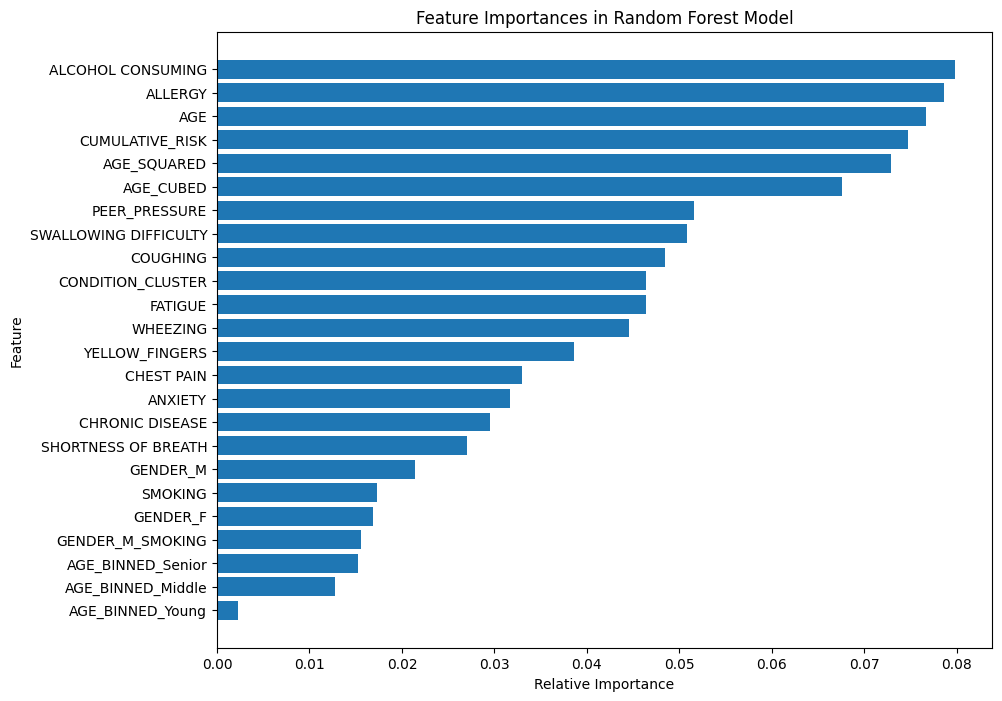

In [15]:
feature_importances = rf_model.feature_importances_

# Sorting the feature importances in descending order
sorted_idx = feature_importances.argsort()

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

In [17]:
import pickle

# Save the trained model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

In [18]:
# Load the model from the file
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Now, you can use loaded_model for predictions

In [21]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score

# Assuming you have already trained your model and made predictions
rf_predictions = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, rf_predictions)

# Log parameters and metrics
mlflow.log_param("n_estimators", rf_model.n_estimators)
mlflow.log_param("max_depth", rf_model.max_depth)
mlflow.log_metric("accuracy", accuracy)

# Log the trained model
mlflow.sklearn.log_model(rf_model, "random_forest_model")
